# Drug/Chemical Reactome Pathways

---
Samir Akre - October 2019

In [7]:
import neo4j_functions.driver as neo4j_driver
import pandas as pd
import importlib
import progressbar
import seaborn as sns
import matplotlib.pyplot as plt

## Importing curated lists of drugs and chemicals

In [8]:
chemical_list_df = pd.read_csv('lib/oxidative_stress_chemicals_SA_10222019.csv')
drug_list_df = pd.read_csv('lib/drug_list_SA_10222019.csv')

In [9]:
chemical_list_df.head(n=2)

,Biological Events of Oxidative Stress,Molecular and Functional Categories,Molecule/Enzyme/Protein,MeSH Heading,MeSH Supplementary,MeSH tree numbers,Chemical Formula,Examples,Pharm Actions,Tree Numbers,References
0,Initiation of Oxidative,Reactive Oxygen Species (ROS),Superoxide (anion radical),Superoxides,NaN,D01.248.497.158.685.750.850; D01.339.431.374.8...,O2-,"Superoxide, Hydrogen Peroxide",Oxidants,"D27.720.642,\nD27.888.569.540",PMID: 25547488
1,Initiation of Oxidative,Reactive Oxygen Species (ROS),Hydrogen Peroxide,Hydrogen Peroxide,NaN,D01.248.497.158.685.750.424; D01.339.431.374.4...,H2O2,NaN,"Anti-Infective Agents, Local",D27.505.954.122.187,NaN


In [10]:
drug_list_df.head(n=2)

,Drug Category,#,Name,Synonyms,MeSH Descriptor,MeSH tree(s),Common adverse effects,Dosage (freq/amount/time/delivery),Duration (time),Pharm Action,...,Unnamed: 1015,Unnamed: 1016,Unnamed: 1017,Unnamed: 1018,Unnamed: 1019,Unnamed: 1020,Unnamed: 1021,Unnamed: 1022,Unnamed: 1023,Unnamed: 1024
0,Anticoagulants,1.0,heparin,"['Calciparine', 'Eparina', 'heparina', 'Hepari...",heparin,D09.698.373.400,"Thrombocytopenia, Cerebral haemorrhage, Haemog...",1/18U/kg/iv,2 days,"Anticoagulants, \nFibrinolytic Agents",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Anticoagulants,2.0,warfarin,"['4-Hydroxy-3-(3-oxo-1-phenylbutyl)coumarin', ...",warfarin,D03.383.663.283.446.520.914\nD03.633.100.150.4...,"Haemorrhage, Haematoma, anaemia, Epistaxis, hy...",1/2-10mg/day/po,As needed,"Anticoagulants, \nRodenticides",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Looking for reactome ids of drugs in curated list
Looks for the lower case name of the drug from the curated list to match any of the lowercase names a drug in reactome is listed in.  

 - Outputs pandas data frame under variable `drugs_in_reactome`
 - 58/155 drugs found to have counter parts in reactome


In [11]:
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

### Test to see if I can find any drug in the reactome data set

In [12]:
driver.search_item_in_array(
    array_field="name",
    item='"herceptin"',
    class_type='Drug',
    info_cols = ['displayName', 'stId', 'isInDisease'],
    verbose=True
)

Query: 
 MATCH (a:Drug) WHERE toLower("herceptin") IN [x in a.name | toLower(x)] RETURN a.displayName, a.stId, a.isInDisease 


,displayName,stId,isInDisease
0,trastuzumab [extracellular region],R-ALL-9634466,True


### Querying to find reactome ID for each drug in curated list

In [13]:
drugs_in_reactome = pd.DataFrame()
for drug_name in drug_list_df.Name.unique():
    result = driver.search_item_in_array(
        array_field="name",
        item='"%s"' % drug_name,
        class_type='Drug',
        info_cols = ['displayName', 'stId', 'isInDisease']
    )
    result['Name'] = drug_name
    drugs_in_reactome = drugs_in_reactome.append(result)
drugs_in_reactome.head()

,displayName,stId,isInDisease,Name
0,warfarin [cytosol],R-ALL-9014945,True,warfarin
0,dabigatran [extracellular region],R-ALL-9015346,True,dabigatran
0,rivaroxaban [extracellular region],R-ALL-9015055,True,rivaroxaban
0,apixaban [extracellular region],R-ALL-9038732,True,apixaban
0,edoxaban [extracellular region],R-ALL-9038742,True,edoxaban


In [14]:
print('Initial Drug List Size: ', drug_list_df.Name.nunique())
print('Drugs found in Reacome: ', drugs_in_reactome.Name.nunique())


Initial Drug List Size:  156
Drugs found in Reacome:  58


In [17]:
caseolap_results = pd.read_csv('lib/caseolap.csv')
drugs_with_caseOLAP = drugs_in_reactome.merge(
    caseolap_results.rename(columns={'protein': 'Name'}),
    how='inner',
    validate='1:1'
)
drugs_with_caseOLAP.head()

,displayName,stId,isInDisease,Name,IoOS,OoOS,RoOS
0,warfarin [cytosol],R-ALL-9014945,True,warfarin,0.077812,0.261603,0.164026
1,dabigatran [extracellular region],R-ALL-9015346,True,dabigatran,0.057181,0.033389,0.057967
2,rivaroxaban [extracellular region],R-ALL-9015055,True,rivaroxaban,0.074862,0.069429,0.054877
3,apixaban [extracellular region],R-ALL-9038732,True,apixaban,0.043904,0.069014,0.028798
4,edoxaban [extracellular region],R-ALL-9038742,True,edoxaban,0.013716,0.000000,0.054452


## Looking for pathways associated with each drug found in the Reactome database

- Looks for 25 "nearest" pathways marked as `Pathways` to any drug within 1-3 nodes
- Outputs to `pathways` variable as a pandas dataframe

In [19]:

# Re-initializing driver to account for changes made to driver function
importlib.reload(neo4j_driver)
driver = neo4j_driver.driver(uri = "bolt://localhost:7687", user = "neo4j", password = "Akre1234")

# For each reactome drug ID, looks for "closest" pathways within 1-2 nodes 
pathways = pd.DataFrame()
for (reactome_id, IoOS, OoOS, RoOS), d_df, in progressbar.progressbar(drugs_with_caseOLAP.groupby(['stId', 'IoOS', 'OoOS', 'RoOS'])):
    result = driver.get_n_relations(
        class_1='Drug',
        id_1="'%s'" % reactome_id,
        id_class='stId',
#        class_2='TopLevelPathway',
        class_2='Pathway',
        info_cols=['a.displayName', 'b.displayName', 'b.speciesName'],
        edge_type='*1..2',
        where_clause=" WHERE b.speciesName = 'Homo sapiens'",
        verbose=False,
        n=10000,
    ).rename(columns={
        'a.displayName': 'Drug',
        'b.displayName': 'Pathway',
        'b.speciesName': 'Species'
    })
    result['IoOS'] = IoOS
    result['OoOS'] = OoOS
    result['RoOS'] = RoOS
    pathways = pathways.append(result, ignore_index=True, sort=False)

pathways.head()

100% (58 of 58) |########################| Elapsed Time: 0:00:15 Time:  0:00:15


,Drug,Pathway,Species,edgeLength,IoOS,OoOS,RoOS
0,warfarin [cytosol],Chaperone Mediated Autophagy,Homo sapiens,2.0,0.077812,0.261603,0.164026
1,warfarin [cytosol],Pink/Parkin Mediated Mitophagy,Homo sapiens,2.0,0.077812,0.261603,0.164026
2,warfarin [cytosol],Receptor Mediated Mitophagy,Homo sapiens,2.0,0.077812,0.261603,0.164026
3,warfarin [cytosol],Microautophagy,Homo sapiens,2.0,0.077812,0.261603,0.164026
4,warfarin [cytosol],Amplification of signal from unattached kine...,Homo sapiens,2.0,0.077812,0.261603,0.164026


In [16]:
pathways['drug'] = pathways['Drug'].str.split(' ').str.get(0)

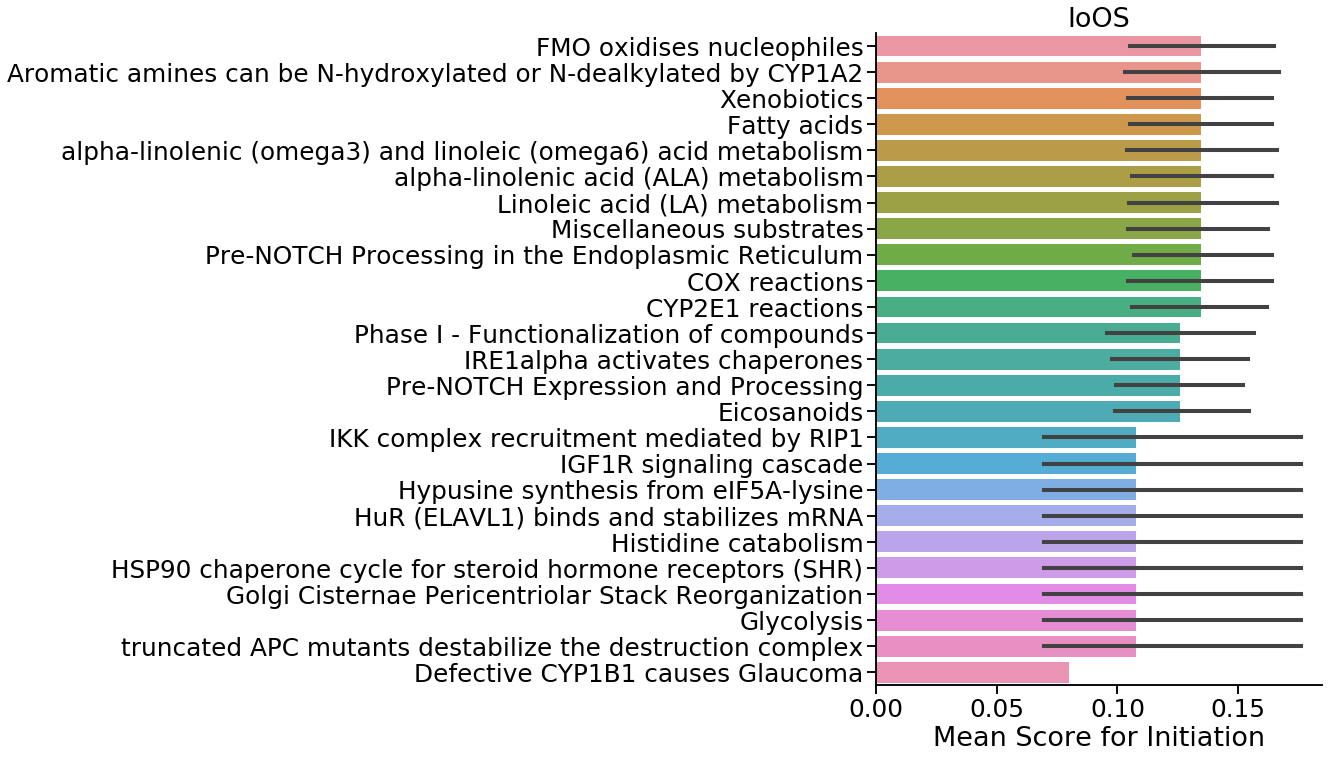

In [41]:
# Pathway by sum score in each category
pathways_IoOS = pd.DataFrame(
    pathways.groupby('Pathway').IoOS.mean()
).reset_index().sort_values(by='IoOS', ascending=False)
pathways_IoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='IoOS',
    order=pd.concat([pathways_IoOS.head(15), pathways_IoOS.tail(10)]).Pathway,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Mean Score for Initiation')
ax.set_ylabel('')
ax.set_title('IoOS')

sns.despine()

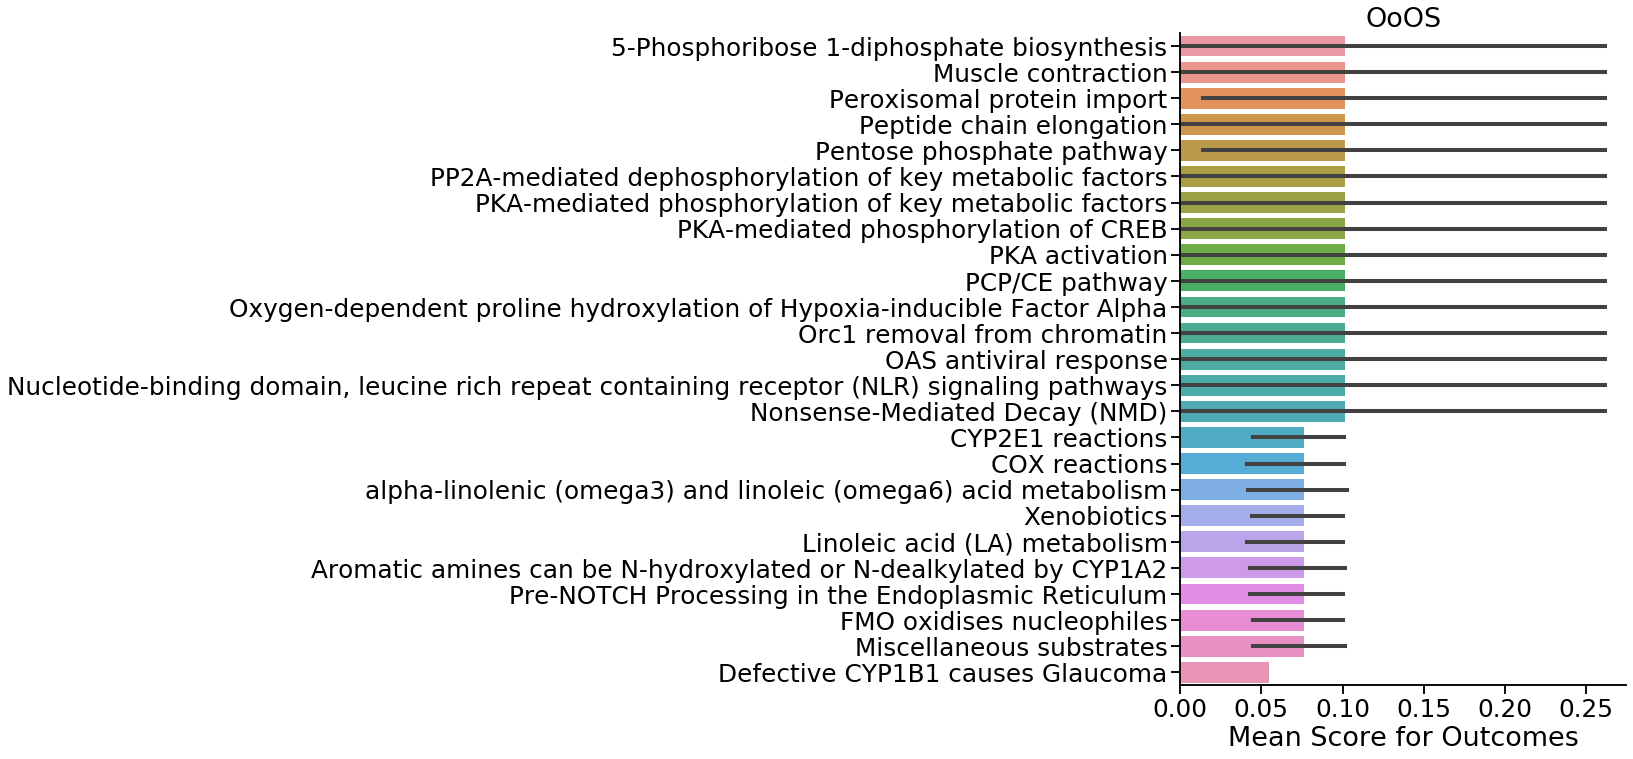

In [40]:
# Pathway by sum score in each category
pathways_OoOS = pd.DataFrame(
    pathways.groupby('Pathway').OoOS.mean()
).reset_index().sort_values(by='OoOS', ascending=False)
pathways_OoOS.head()

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='OoOS',
    order=pd.concat([pathways_OoOS.head(15), pathways_OoOS.tail(10)]).Pathway,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Mean Score for Outcomes')
ax.set_ylabel('')
ax.set_title('OoOS')

sns.despine()

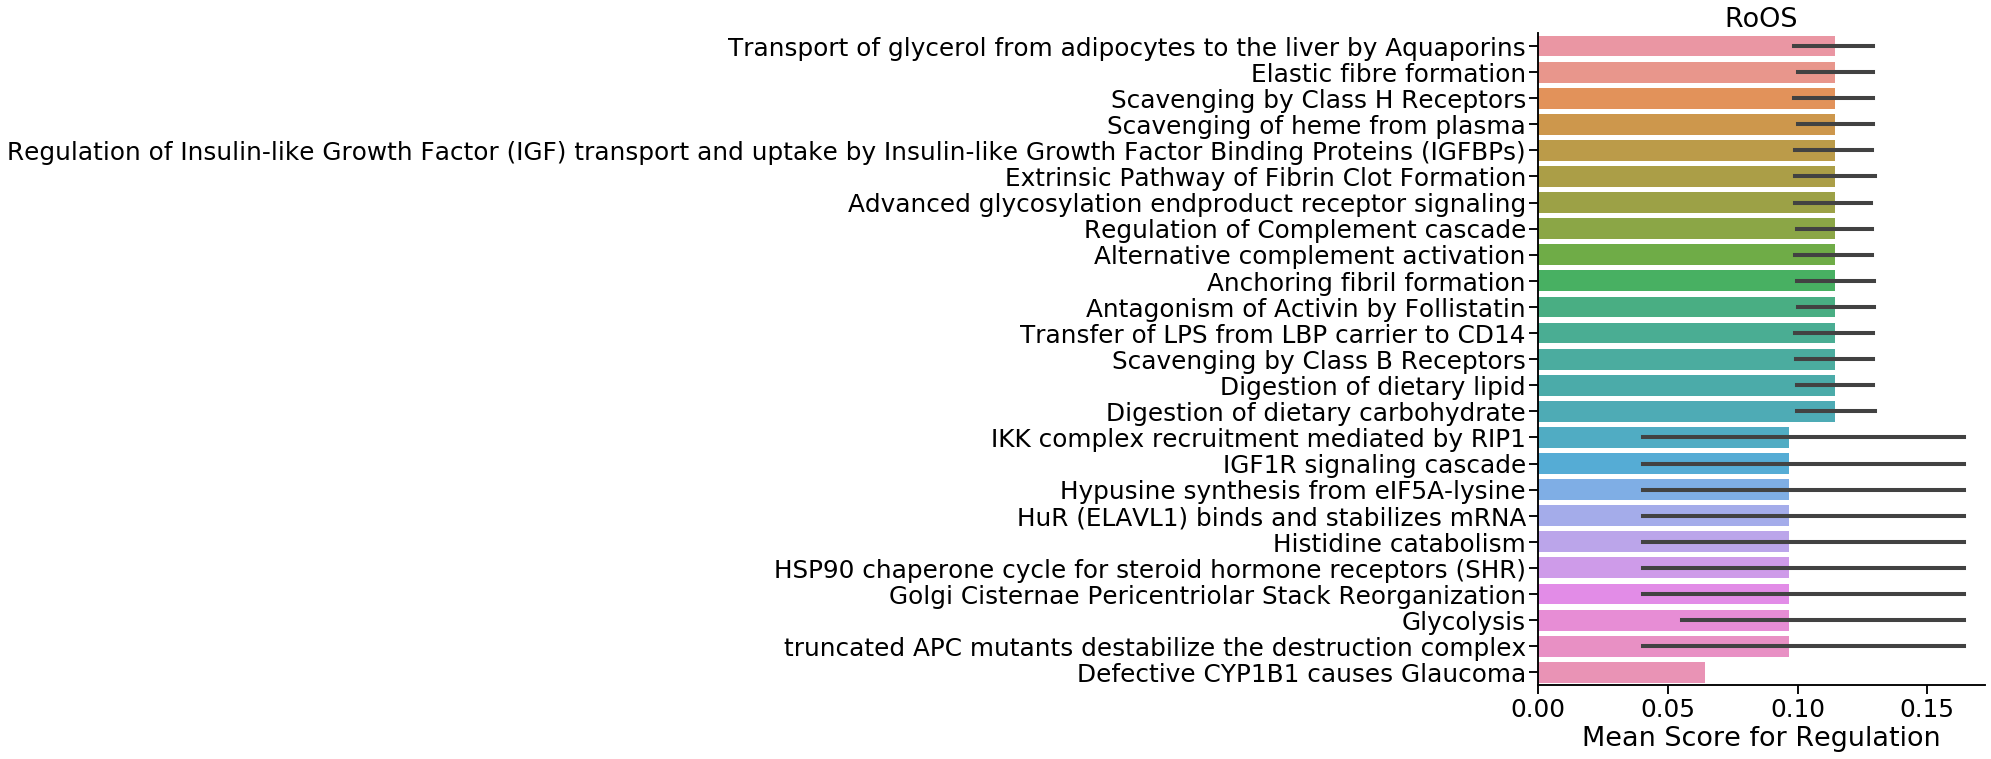

In [37]:
# Pathway by mean score in each category
pathways_RoOS = pd.DataFrame(
    pathways.groupby('Pathway').RoOS.mean()
).reset_index().sort_values(by='RoOS', ascending=False)

# Plotting top 15 and bottom 10 pathways
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.barplot(
    y='Pathway',
    x='RoOS',
    order=pd.concat([pathways_RoOS.head(15), pathways_RoOS.tail(10)]).Pathway,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Mean Score for Regulation')
ax.set_ylabel('')
ax.set_title('RoOS')

sns.despine()

In [17]:
# Number of drugs per pathway, seperated by edgelength
drugs_per_pathway = pd.DataFrame(pathways.groupby(['Pathway', 'edgeLength']).drug.nunique()).reset_index().sort_values(by=['edgeLength', 'drug'], ascending=[True, False])

In [18]:
# Number of pathways per drug, seperated by edgeLength
pathways_per_drug = pd.DataFrame(pathways.groupby(['drug', 'edgeLength']).Pathway.nunique()).reset_index().sort_values(by=['edgeLength', 'Pathway'], ascending=[True, False])

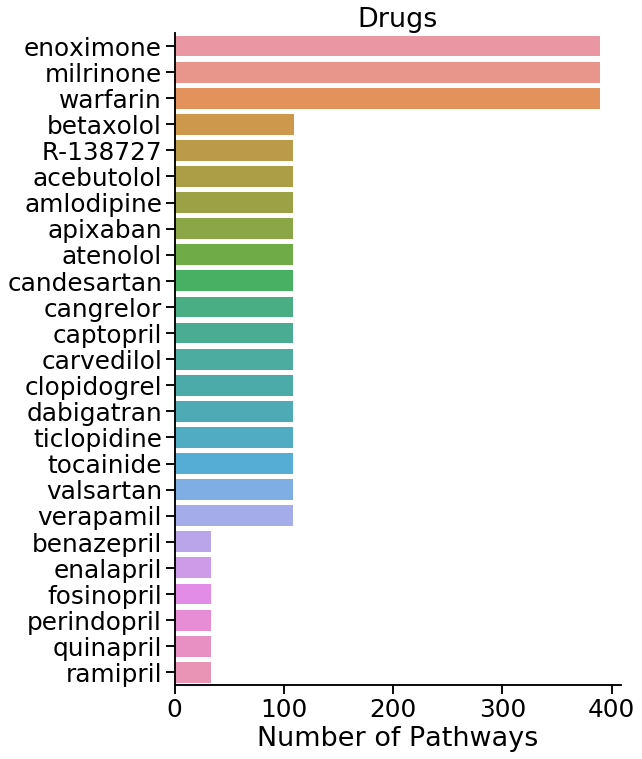

In [19]:
# Plotting top 15 and bottom 10 drugs
sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.countplot(
    y='drug',
    order=pd.concat([pathways_per_drug.head(15), pathways_per_drug.tail(10)]).drug,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Number of Pathways')
ax.set_ylabel('')
ax.set_title('Drugs')

sns.despine()

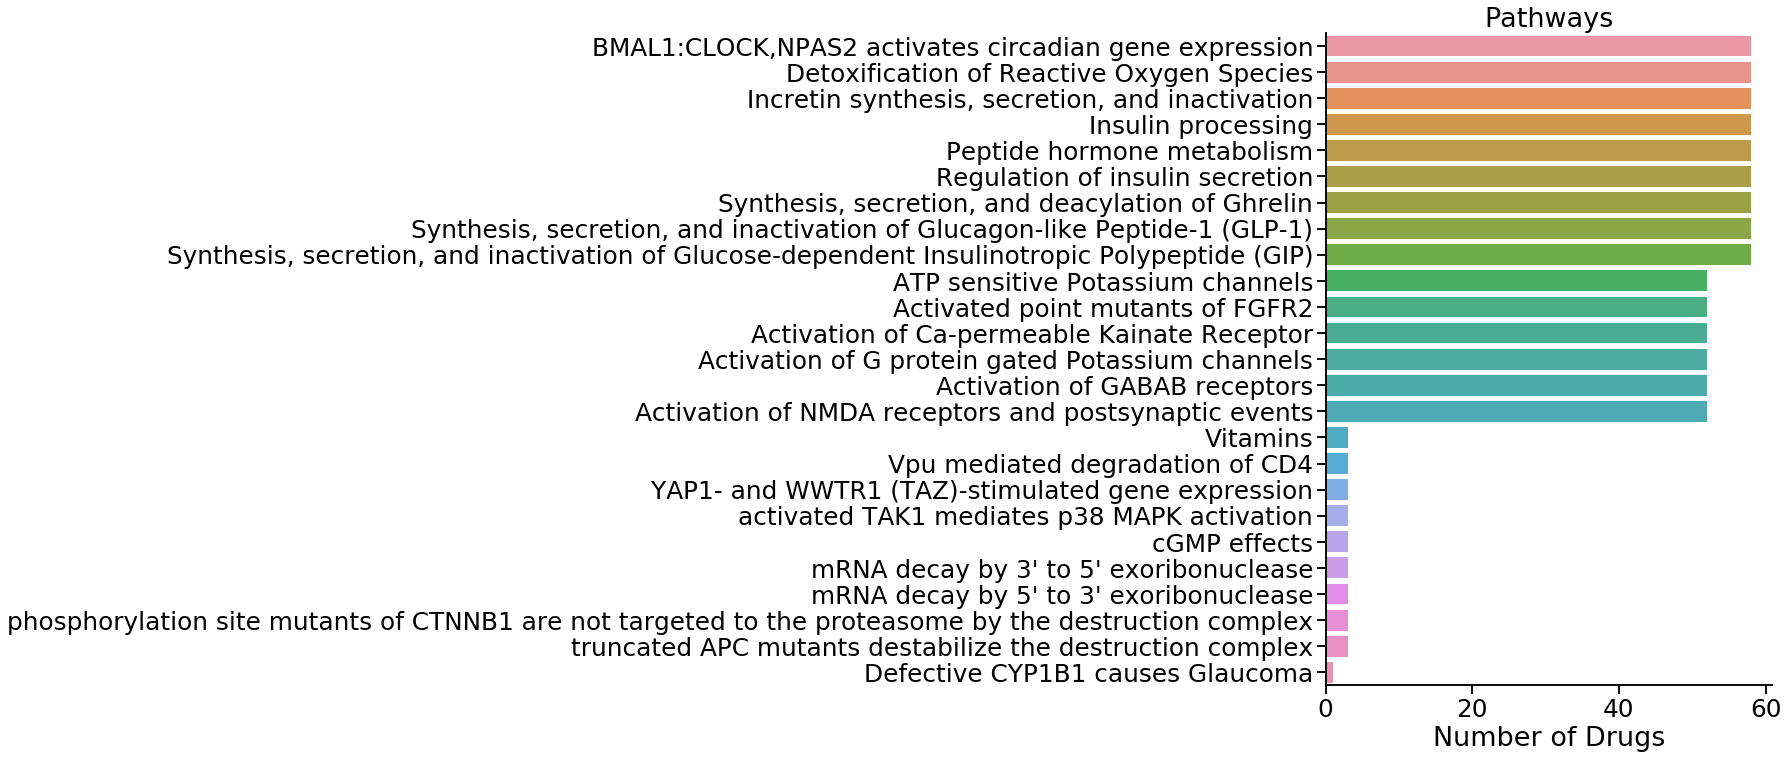

In [20]:
# Plotting top 15 and bottom 10 pathways

sns.set_context('talk', font_scale=1.5)
fig, ax = plt.subplots(figsize=(8, 12))
sns.countplot(
    y='Pathway',
    order=pd.concat([drugs_per_pathway.head(15), drugs_per_pathway.tail(10)]).Pathway,
    data=pathways,
    ax=ax
)
ax.set_xlabel('Number of Drugs')
ax.set_ylabel('')
ax.set_title('Pathways')

sns.despine()

## Test Cypher Queries in custom neo4j driver implementation

In [59]:
driver.get_node_info(
    id_field="stId",
    id_val="R-ALL-9634956",
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease']
)

Query: 
 MATCH (a:Drug {stId: $idnum}) RETURN a.displayName, a.name, a.isInDisease 
pyridostigmine [extracellular region]
['pyridostigmine']
True


,displayName,name,isInDisease
0,pyridostigmine [extracellular region],[pyridostigmine],True


In [131]:
driver.get_n_nodes_info(
    class_type='Drug',
    info_cols = ['displayName', 'name', 'isInDisease'],
    n=10
)

Query: 
 MATCH (a:Drug) RETURN a.displayName, a.name, a.isInDisease LIMIT 10


,displayName,name,isInDisease
0,trastuzumab [extracellular region],"[trastuzumab, herceptin, D5v8, R-597]",True
0,CP-724714 [cytosol],[CP-724714],True
0,Afatinib [cytosol],"[Afatinib, BIBW2992, Irreversible TKI inhibito...",True
0,AZ5104 [cytosol],[AZ5104],True
0,Sapitinib [cytosol],[Sapitinib],True
0,Tesevatinib [cytosol],"[Tesevatinib, EXEL-7647, XL-647, KD-019, XL647]",True
0,Lapatinib [cytosol],"[Lapatinib, GW572016, Tykerb, Reversible tyros...",True
0,Neratinib [cytosol],"[Neratinib, HKI-272, afatinib, Irreversible ty...",True
0,AEE788 [cytosol],[AEE788],True
0,Canertinib [cytosol],"[Canertinib, CI-1033, Irreversible TKI inhibit...",True


## Enriching pathway data with caseOLAP score
- input from caseolap pipeline found in `lib/caseolap.csv`